# Setup

## Load and install packages

In [1]:
# %%capture
# !pip install PyMuPDF
# !pip install -U nltk
# !brew install qpdf
# !pip install pikepdf
# !pip install ocrmypdf -U
# !brew install tesseract
# !pip install pytesseract
# !pip install icecream
# !pip install Unidecode
# !pip install pngquant


In [2]:
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
from icecream import ic
import fitz 
from PIL import Image
import re
import pngquant
from unidecode import unidecode 

%matplotlib inline

## PDF Helper Functions

In [3]:
def get_pdf(path):
    '''Reads a PDF file and returns a PdfDocument object.'''
    doc = fitz.open(path)
    return doc

def render(page):
    '''Render a page to a PIL image.'''
    bitmap = page.render(
        scale = 1,    # 72dpi resolution
        rotation = 0, # no additional rotation
    )
    return bitmap.to_pil()

# cleanup content using regex
def clean_characters(text):
    text = unidecode(text) # convert to ascii
    # text = re.sub(r"[^a-zA-Z0-9:.,?£$€%'\n]+", ' ', text)
    # clean_text = ' '.join( [w for w in text.split() if len(w)>1] )
    return text

def extract_content_from_id(file_id: str) -> str :    
    # extract filename and page
    items = file_id.split('.')
    filename = '.'.join(items[:2])
    page_num = int(items[-1])-1
    
    # load pdf, select page, and extract its content
    filepath = os.path.join(report_path, filename) #path to the report
    doc = get_pdf(filepath) # load the pdf
    page = doc.load_page(page_num) # select the page from the pdf
    content = page.get_text("text", sort = True, flags=fitz.TEXT_INHIBIT_SPACES) # extract the text from the page
    content = clean_characters(content) # replace unrecognized characters
    return content

def render_content_from_id(file_id: str) -> str :    
    # extract filename and page
    items = file_id.split('.')
    filename = '.'.join(items[:2]) # reconstruct the report name
    page_num = int(items[-1])-1
    
    # load pdf, select page, and extract its content
    filepath = os.path.join(report_path, filename) #path to the report
    doc = get_pdf(filepath) # load the report pdf
    dpi = 150  # set the dpi
    mat = fitz.Matrix(dpi / 72, dpi / 72)  # sets zoom factor
    pix = doc[page_num].get_pixmap(matrix=mat)
    img_page = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    return img_page

## Set path for folder

- choose one of the following blocks: online if run directly on Kaggle, local if data downloaded

In [4]:
# # kaggle online path
# basepath = "/kaggle/input/oxml2023mlcases-esg-classifier/data/"
# report_path = os.path.join(basepath, "reports")
# label_path = os.path.join(basepath, "labels.csv")

In [5]:
# local data path using pathlib

# main folder
basepath = '/Users/mbp14/Desktop/GoogleDrive/OxML_2023/code/Kaggle'

# build get path function, input folder name (as a list) and file name (optional), return the path
def get_path(folder_name: list, file_name=None):
    path = Path(basepath)
    for folder in folder_name:
        path = path / folder
    if file_name:
        path = path / file_name
    return path

# report path
report_path = get_path(["data", "reports"])

# label path
label_path = get_path(["data"], "labels.csv")


In [6]:

print("Report path: ", report_path)
print("Label path: ", label_path)

Report path:  /Users/mbp14/Desktop/GoogleDrive/OxML_2023/code/Kaggle/data/reports
Label path:  /Users/mbp14/Desktop/GoogleDrive/OxML_2023/code/Kaggle/data/labels.csv


# Improve PDF Parsing

## Fitz OCR through Tesseract

In [7]:
# Version 1: using PyMuPDF builtin ocr_the_page function
# require Tesseract OCR installed

import ocrmypdf
import sys
import io

ocrmypdf.configure_logging(verbosity = -1)

def ocr_the_page(page):
    """Extract the text from passed-in PDF page."""    
    src = page.parent  # the page's document
    doc = fitz.open()  # make temporary 1-pager
    doc.insert_pdf(src, from_page=page.number, to_page=page.number)
    pdfbytes = doc.tobytes()
    inbytes = io.BytesIO(pdfbytes)  # transform to BytesIO object
    outbytes = io.BytesIO()  # let ocrmypdf store its result pdf here

    # run ocr and get result pdf as bytes
    ocrmypdf.ocr(
        inbytes,  # input 1-pager
        outbytes,  # ouput 1-pager
        language="eng",  # modify as required e.g. ("eng", "ger")
        output_type="pdf",  # only need simple PDF format
        # add more paramneters, e.g. to enforce OCR-ing, etc., e.g.
        force_ocr=True, 
        # redo_ocr=True
        progress_bar=False,
        optimize=1,
    )
    
    # read result pdf as fitz document
    ocr_pdf = fitz.open("pdf", outbytes.getvalue())  # read output as fitz PDF
    text = ocr_pdf[0].get_text()  # and extract text from the page
    return text  # return it

# build function to extract page from file_id then call function `ocr_the_page`
def extract_content_from_id_ocr(file_id: str) -> str :
    # extract filename and page
    items = file_id.split('.')
    filename = '.'.join(items[:2])
    page_num = int(items[-1])-1
    
    # load pdf, select page, and extract its content
    filepath = os.path.join(report_path, filename) #path to the report
    doc = get_pdf(filepath) # load the pdf
    page = doc[page_num] # select the page from the pdf
    
    content = ocr_the_page(page)
    
    return content
    

In [8]:

# # Version 2: using PyMuPDF with Partial OCR
# # doesn't work, require setting environment variable TESSDATA_PREFIX

# test following code
# env \
#     PATH=/home/user/src/tesseract/api:$PATH \
#     TESSDATA_PREFIX=/home/user/src/tesseract \
#     ocrmypdf input.pdf output.pdf

# def extract_content_from_id_ocr_partial(file_id: str) -> str :    
#     # extract filename and page
#     items = file_id.split('.')
#     filename = '.'.join(items[:2])
#     page_num = int(items[-1])-1
    
#     # load pdf, select page
#     filepath = os.path.join(report_path, filename) #path to the report
#     doc = get_pdf(filepath) # load the pdf
#     page = doc[page_num] # select the page from the pdf
    
#     # extract content
#     partial_tp = page.get_textpage_ocr(flags=0, full=False)
#     content = page.get_text(textpage=partial_tp, sort=True)

#     return content

## Pytesseract

- [link Kaggle here](https://www.kaggle.com/code/juniorbueno/opencv-ocr-and-tesseract/notebook)

- install with `!apt-get install tesseract-ocr-eng`
- somehow install `pip install google.colab` ??

In [9]:
# place holder

## Test parsing

### Few token sample

In [10]:
# build path to data file in process folder
sample_path = get_path(["process"], "sample_few_token.csv")

# load sample file from csv
sample_few_token = pd.read_csv(sample_path, index_col=None)

In [11]:
# # render pages
# for idx, row in sample_few_token.iterrows():
#     file_id, label = row['id'], row['class']
#     ic(file_id, label)        
#     img = render_content_from_id(file_id)
#     display(img)

In [12]:
# test extract content, with and without ocr
for idx, row in sample_few_token.iterrows():
    file_id, label = row['id'], row['class']
    test_no_ocr = extract_content_from_id(file_id)
    # test_with_ocr = extract_content_from_id_ocr(file_id)
    
    print(f'*** start testing:[{file_id}], [{label}] *** \n')
    # print('\n *** with OCR *** \n')
    # print(test_with_ocr)
    print('\n *** no OCR *** \n')
    print(test_no_ocr)
    print(f'*** end test *** \n\n')



*** start testing:[report_1826.pdf.55], [other] *** 


 *** no OCR *** 

Further articles on the subject at:
audi.com/talking-business

*** end test *** 


*** start testing:[report_810.pdf.14], [social] *** 


 *** no OCR *** 

OUR PEOPLE
WORKFORCE DEMOGRAPHICS
Americas: 54% 
8,400+
employees
worldwide 
Asia: 41% 
Europe: 5% 
Represented by 
a Works Council/
Trade Union
12
% 
2
% 
Represents foreign 
nationals (worldwide)
We employ 8,400+ people who are 
dedicated to delivering innovative 
technologies and products.
FY21 Sustainability Report
14

*** end test *** 


*** start testing:[report_833.pdf.50], [social] *** 


 *** no OCR *** 

Investing in our 
Communities

*** end test *** 


*** start testing:[report_279.pdf.17], [social] *** 


 *** no OCR *** 

People
People
E2open's team members are at the heart of the company. Our 
diverse and inclusive work environment supports ingenuity and 
creative problem-solving focused on doing what's right in business, 
in our communities, and

### Long token sample

In [13]:
# build path to data file in process folder
sample_path = get_path(["process"], "sample_long_token.csv")

# load sample file from csv
sample_long_token = pd.read_csv(sample_path, index_col=None)

In [14]:
# # render pages
# for idx, row in sample_long_token.iterrows():
#   file_id, label = row['id'], row['class']
#   ic(file_id, label)        
#   img = render_content_from_id(file_id)
#   display(img)

In [15]:
# test extract content, with and without ocr
for idx, row in sample_long_token.iterrows():
    file_id, label = row['id'], row['class']
    test_no_ocr = extract_content_from_id(file_id)
    # test_with_ocr = extract_content_from_id_ocr(file_id)
    
    print(f'*** start testing:[{file_id}], [{label}] *** \n')
    # print('\n *** with OCR *** \n')
    # print(test_with_ocr)
    print('\n *** no OCR *** \n')
    print(test_no_ocr)
    print(f'*** end test *** \n\n')

*** start testing:[report_1829.pdf.157], [other] *** 


 *** no OCR *** 

 
D _ Consolidated Financial Statements 
 
 
 
 
 
 
 
 
 
 
% 
% 
% 
  
  
  
owned1  
owned1  
owned1  
Windpark Eckolstadt GmbH & Co. KG, 
Sehestedt 
100.0   
Umspannwerk Putlitz GmbH & Co. KG, 
Oldenburg 
25.4   
AZV-Argos 77 
Vermogensverwaltungsgesellschaft mbH, 
Munich 
100.0   
Verimi GmbH, Frankfurt am Main 
14.8 8 
Windpark Emmendorf GmbH & Co. KG, 
Sehestedt 
100.0   
Windkraft Kirf Infrastruktur GmbH,  
Neumagen-Dhron 
50.0 8 
AZV-Argos 82 
Vermogensverwaltungsgesellschaft mbH, 
Munich 
100.0   
Windpark Freyenstein-Halenbeck GmbH & Co. 
KG, Sehestedt 
100.0   
  
    
Windpark Kesfeld-Heckhuscheid GmbH & Co. 
KG, Sehestedt 
100.0   
FOREIGN ENTITIES 
    
AZV-Argos 87 
Vermogensverwaltungsgesellschaft mbH, 
Munich 
100.0   
Windpark Kirf GmbH & Co. KG, Sehestedt 
100.0   
Consolidated affiliates 
    
BrahmsQ Objekt GmbH & Co. KG, Stuttgart 
94.8   
Windpark Kittlitz GmbH & Co. KG, Sehestedt 
100.0  

### Short token sample

In [16]:
# build path to data file in process folder
sample_path = get_path(["process"], "sample_short_token.csv")

# load sample file from csv
sample_short_token = pd.read_csv(sample_path, index_col=None)

In [17]:
# # render pages
# for idx, row in sample_short_token.iterrows():
#   file_id, label = row['id'], row['class']
#   ic(file_id, label)        
#   img = render_content_from_id(file_id)
#   display(img)
    

In [18]:
# test extract content, with and without ocr
for idx, row in sample_short_token.iterrows():
    file_id, label = row['id'], row['class']
    test_no_ocr = extract_content_from_id(file_id)
    # test_with_ocr = extract_content_from_id_ocr(file_id)
    
    print(f'*** start testing:[{file_id}], [{label}] *** \n')
    # print('\n *** with OCR *** \n')
    # print(test_with_ocr)
    print('\n *** no OCR *** \n')
    print(test_no_ocr)
    print(f'*** end test *** \n\n')

*** start testing:[report_1825.pdf.142], [other] *** 


 *** no OCR *** 

CORPORATE GOVERNANCE 
3.2 EXECUTIVE COMPENSATION AND SHARE OWNERSHIP 
3
Date of the 
Shareholders' Meeting
 
22/04/2008
22/04/2008
22/04/2008
22/04/2008
22/04/2008
27/04/2011
27/04/2011
27/04/2011
27/04/2011
23/04/2014 
 
 
 
 
 
 
 
 
 
 
13/10/2010 
22/12/2010 
18/03/2011 
18/03/2011 
04/04/2011 
16/03/2012 
13/06/2012 
22/03/2013 
24/03/2014 
19/06/2015 
Grant date 
(Board of Directors or
Management Board) 
Total number 
of beneficiaries 
17 
8 
6,372 
423 
170 
467 
1 
162 
158 
148 
Total number of shares 
to be subscribed (a) 
or purchased, from 
which to be subscribed 
or purchased by: 
27,772 
12,758 
8,598,469 
154,705 
375,988 
4,508,380 
76,089 
3,480,637 
3,100,000 
3,014,469 
corporate of icers: 
Thomas Buberl 
-
-
-
-
-
-
-
-
-
-
Denis Duverne 
-
-
247,500 
-
-
192,000 
-
169,000 
155,000 
145,381 
Doina Palici-Chehab 
-
-
8,750 
-
-
7,500 
-
14,000 
14,110 
13,461 
The first 10 employees 
beneficia

## Insights for parsing pdf

- clean up text with Regex: good efficiency, faster than OCR
- text in boxes: replace unrecognized characters with space
  - sometimes characters are separated one by one
- link: replace '/' with space

 <!-- -->
 

- OCR: not helpful at this stage
  - few token: not helpful, introduce artefact from image
  - long token: sometimes helpful, for text embedded inside charts and boxes 
    - report_1828.pdf.36: should be 'env' ?
    - report_1824.pdf.287: should be 'social' ? There are ESG sections.
  - short token: not helpful, most tables are read correctly
 <!-- -->
 
- duplicate reports: 1830, 1831
  - 1831 has missing pages


# Test examples

## Need OCR

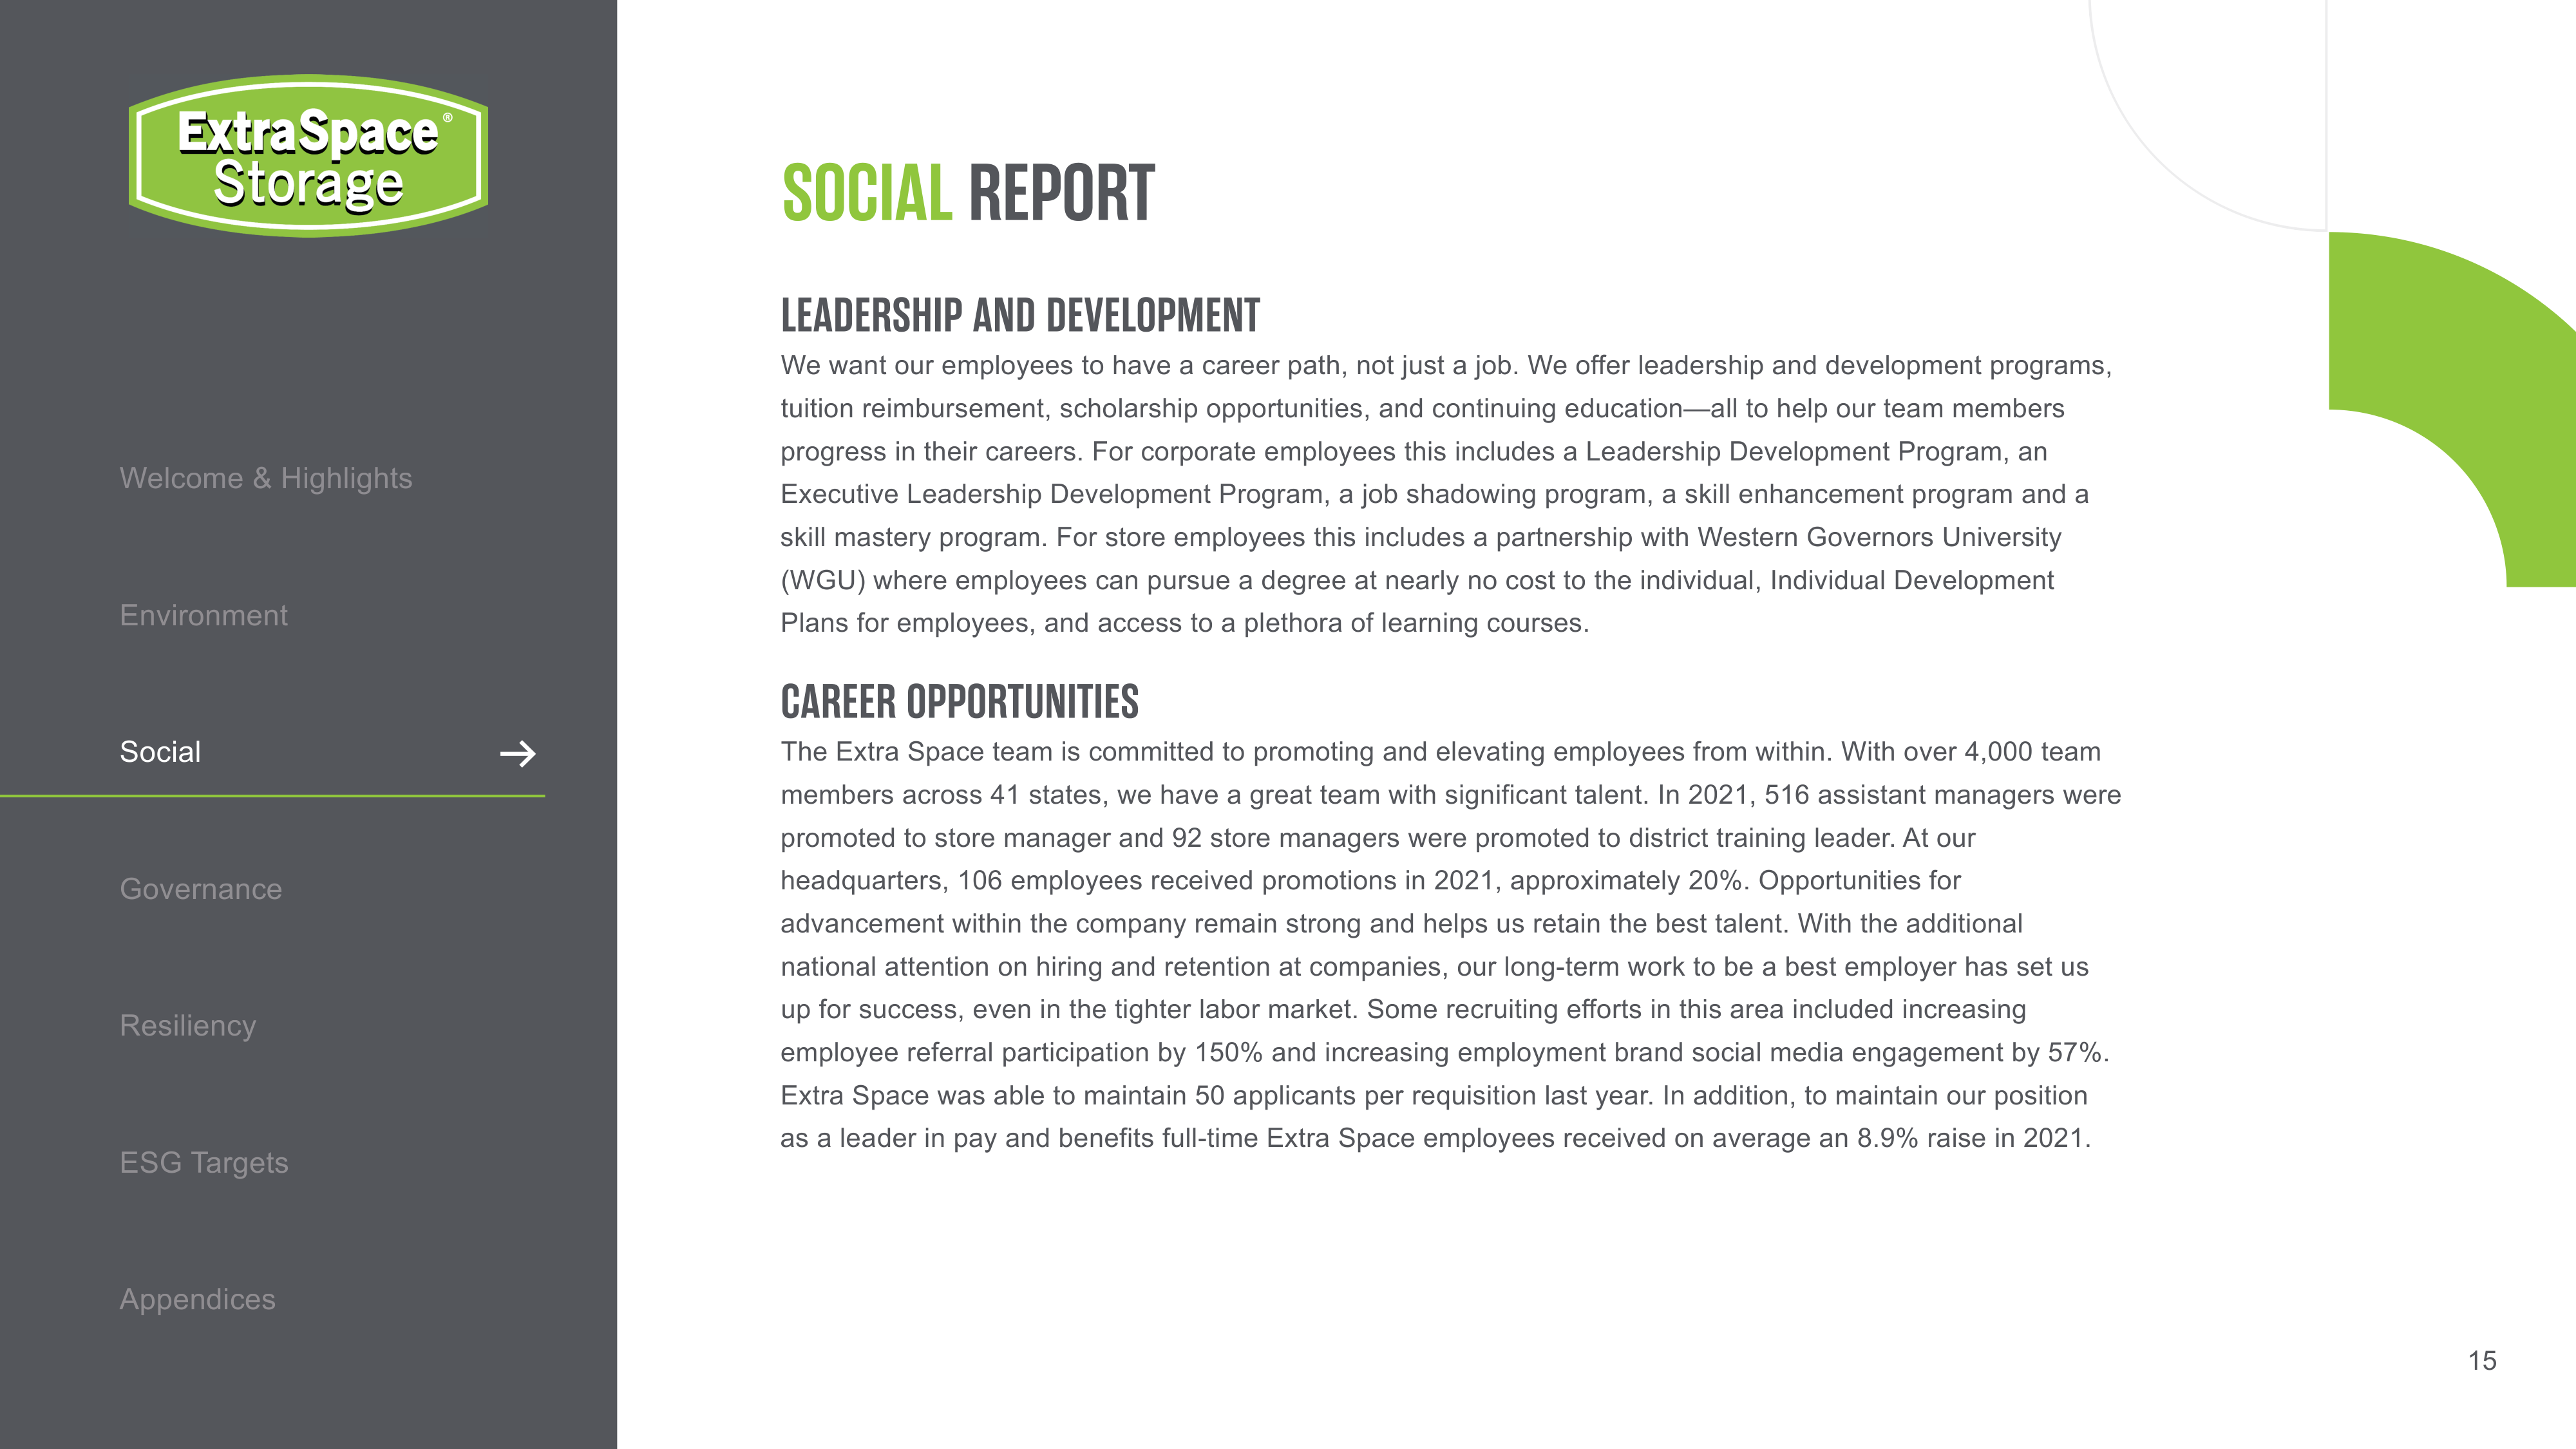

In [19]:
# load file id
file_id = 'report_1611.pdf.16'

# render the page
render_content_from_id(file_id)

In [20]:
# extract content from the page
test_no_ocr = extract_content_from_id(file_id)
test_with_ocr = extract_content_from_id_ocr(file_id)

print(f'*** start testing:[{file_id}] *** \n')
print('\n *** with OCR *** \n')
print(test_with_ocr)
print('\n *** no OCR *** \n')
print(test_no_ocr)
print(f'*** end test *** \n\n')

*** start testing:[report_1611.pdf.16] *** 


 *** with OCR *** 

Social 
REPORT 
LEADERSHIP AND DEVELOPMENT 
We want our employees to have a career path, not just a job. We offer leadership and development programs, 
tuition reimbursement, scholarship opportunities, and continuing education—all to help our team members 
progress in their careers. For corporate employees this includes a Leadership Development Program, an 
Executive Leadership Development Program, a job shadowing program, a skill enhancement program and a 
skill mastery program. For store employees this includes a partnership with Western Governors University 
(WGU) where employees can pursue a degree at nearly no cost to the individual, Individual Development 
Plans for employees, and access to a plethora of learning courses. 
CAREER OPPORTUNITIES 
The Extra Space team is committed to promoting and elevating employees from within. With over 4,000 team 
members across 41 states, we have a great team with significant tal